# Digital Music Store

In this project I'll be answering some business questions about the Chinook store. Chinook is like a small, fictional iTunes store, and its database contains data extracted from iTunes.

You can find the database and the documentation in this [github repository](https://github.com/lerocha/chinook-database). I'll be using a modified version of the database for my analysis which can be found in the repository along with this project.

## Chinook Schema

The schema for the Chinook database is shown below as a visual aid to understanding the data contained within the database and how it is organized. At the top of each table is the table name. The rows highlighted in yellow are the primary keys. Lines connecting the tables show their relationships.

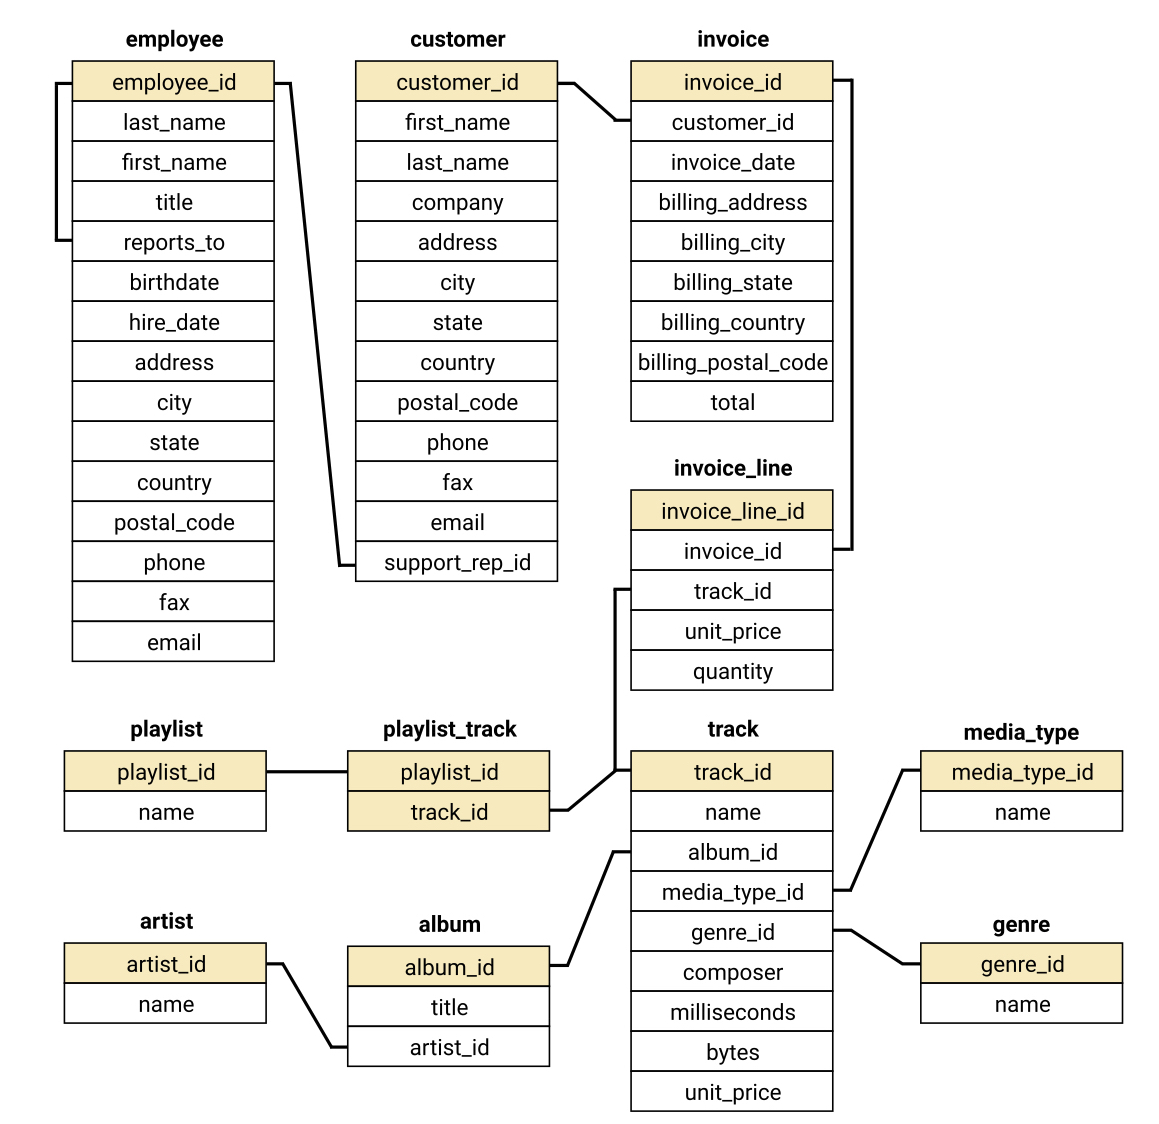

In [1]:
# Import module to display images.
from IPython.display import Image
Image('chinook_schema.jpg')

### Connecting to and exploring the data

The cell below connects directly to the database allowing us to write queries directly from Jupyter Notebook.

We'll start by exploring the tables and views in list form.

In [38]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

In [22]:
%%sql
-- To execute SQL query in Jupyter, add %%sql alone at start of query.

-- Explore the database by getting a list of all tables and views.
SELECT
    name Name,
    type Type
FROM sqlite_master
WHERE type IN ("table","view");

 * sqlite:///chinook.db
Done.


Name,Type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


## Selecting products to add to the store

Chinook has recently signed a deal with a new record label. The record label has given us some money to advertise three new albums in the USA. We must choose three of four possible albums to add to the store.

The artists on the potential albums are all new to the store. The information we have about the albums is that the artists are all from the USA and their genres as listed in the following table . 


|Artist Name|Genre|
|-----------|-----|
|Regal|Hip-Hop|
|Red Tone|Punk|
|Meteor and the Girls|Pop|
|Slim Jim Bites|Blues|



### Best-selling genres in the USA

We want to get an idea of what the best-selling genres are in the USA. Based on the top-selling genres, we can make a recommendation for which three albums to add to the store.

In [39]:
%%sql

-- Limit analysis to tracks sold in USA.
WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

-- Get a table of the most popular genres.
SELECT
    g.name Genre,
    count(uts.invoice_line_id) Tracks_Sold, -- Absolute numbers sold in USA.
    cast(count(uts.invoice_line_id) AS FLOAT) * 100/ (
        SELECT COUNT(*) from usa_tracks_sold
    ) Percentage_Sold -- Percentage of tracks sold in USA.
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;

 * sqlite:///chinook.db
Done.


Genre,Tracks_Sold,Percentage_Sold
Rock,561,53.37773549000951
Alternative & Punk,130,12.369172216936251
Metal,124,11.798287345385347
R&B/Soul,53,5.042816365366318
Blues,36,3.4253092293054235
Alternative,35,3.330161750713606
Pop,22,2.093244529019981
Latin,22,2.093244529019981
Hip Hop/Rap,20,1.9029495718363463
Jazz,14,1.3320647002854424


### Recommendation

Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:

|Artist Name|Genre|Percentage Sold|
|-----------|-----|---------------|
|Red Tone|Punk|12%|
|Meteor and the Girls|Pop|2%|
|Slim Jim Bites|Blues|3%|

Of the four genres we have available to us, Hip-Hop is the least sold in the USA with less than 2% of tracks sold.

Despite being the top 3 available to us, these three genres only make up only 17% of total sales. We should stay on the lookout for artists and albums from the "Rock" genre, which accounts for 53% of sales in the USA.

---
## Evaluating employee performance

Each Chinook customer is assigned to a sales support agent. We've been asked to analyze customer purchases in order to evaluate employee performance. For our evaluation, we'll take a look at the total dollar amount of sales assigned to each support agent along with the length of time each agent has been working at Chinook.

In [41]:
%%sql

SELECT
    e.first_name||" "||e.last_name Employee_Name,
    e.title Title,
    e.hire_date Hire_Date,
    ct.total Total
FROM employee e
LEFT JOIN
    (SELECT
        c.support_rep_id,
        c.customer_id,
        SUM(i.total) total -- Sum of invoices grouped by employee.
     FROM customer c
     LEFT JOIN invoice i ON c.customer_id=i.customer_id
     GROUP BY 1
    ) ct ON e.employee_id=ct.support_rep_id
GROUP BY 1 ORDER BY 4 DESC;

 * sqlite:///chinook.db
Done.


Employee_Name,Title,Hire_Date,Total
Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,1731.510000000004
Margaret Park,Sales Support Agent,2017-05-03 00:00:00,1584.0000000000032
Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,1393.9200000000028
Robert King,IT Staff,2017-01-02 00:00:00,None
Nancy Edwards,Sales Manager,2016-05-01 00:00:00,None
Michael Mitchell,IT Manager,2016-10-17 00:00:00,None
Laura Callahan,IT Staff,2017-03-04 00:00:00,None
Andrew Adams,General Manager,2016-08-14 00:00:00,None


The sales support agents have made money somewhat in proportion to their length of time working at the company. It seems that no one agent's performance stands out either as above or below average as they all have similar sales per day rates.

---

## Sales by country

Our manager has asked us to analyze the sales data for customers by country. We're to use the country listed in the `customer` table as opposed to the that in the billing address in the `invoice` table.

Many countries in our database have only one customer. We'll group these together into an "Other" category. 

### Goal
We want to get a table of sales by country sorted from most to least sales with the "Other" category at the bottom of the table.

Here is a walkthrough of the following query:

WITH 
1. joined tables of relevant info, totaled up amount spent and counted invoices, grouped by customer
2. got amount spent, number of customers, and number of orders per country
3. create "new_country" column relisting countries with only one customer as "Other," use this column as country name moving forward
4. grouped by new country to use "Other" grouping. listed: country, number of customers, total spent, and number of orders, all per country

ACTUAL QUERY

from last (4th) WITH table, returned: country, customers, total spent, and calculated averages per country (GROUP BY country). added a CASE in FROM to force sort "Other" to bottom of list. ORDER BY sort (column not shown, used just to force "Other" to bottom) and then total spent from most to least.

In [46]:
%%sql

WITH orders_by_country AS
    (
    SELECT
        c.country,
        SUM(i.total) total,
        COUNT(i.invoice_id) number_orders
    FROM customer c
    INNER JOIN invoice i ON c.customer_id=i.customer_id
    GROUP BY c.customer_id
    ),
customers_by_country AS
    (
    SELECT 
        country,
        SUM(total) total,
        COUNT(*) number_of_customers,
        SUM(number_orders) number_orders
    FROM orders_by_country
    GROUP BY country
    ),
cust_country_other AS
    (
    SELECT
        *,
        CASE number_of_customers
            WHEN 1 THEN "Other"
            ELSE country
        END AS new_country
    FROM customers_by_country
    ),
country_cust_total AS
    (
    SELECT 
        new_country country,
        SUM(number_of_customers) customers,
        SUM(total) total_spent,
        SUM(number_orders) number_orders
    FROM cust_country_other
    GROUP BY new_country
    )

SELECT
    country Country,
    customers Customers,
    SUM(total_spent) Total_Spent,
    AVG(total_spent/number_orders) Avg_Order_Val,
    AVG(total_spent/customers) Avg_Val_Per_Customer
FROM 
    (
    SELECT
        *,
        CASE country
            WHEN "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_cust_total
    )
GROUP BY country
ORDER BY sort ASC, total_spent DESC

 * sqlite:///chinook.db
Done.


Country,Customers,Total_Spent,Avg_Order_Val,Avg_Val_Per_Customer
USA,13,1040.49,7.942671755725191,80.03769230769231
Canada,8,535.59,7.047236842105264,66.94875
Brazil,5,427.67999999999995,7.011147540983606,85.53599999999999
France,5,389.07,7.7814,77.814
Germany,4,334.62,8.161463414634147,83.655
Czech Republic,2,273.24,9.108,136.62
United Kingdom,3,245.51999999999998,8.768571428571429,81.83999999999999
Portugal,2,185.13,6.3837931034482756,92.565
India,2,183.14999999999998,8.72142857142857,91.57499999999999
Other,15,1094.9399999999998,7.4485714285714275,72.996


### Highest value customers

It may be worthwhile to focus advertising efforts on the countries whose customers tend to spend the most. The three countries with the top spending amount per customer are:
* Czech Republic
* United Kingdom
* India

However, all of the customer numbers are low. The sample size is too small to be worth investing in a large advertising budget.

---
## Money saving strategy

Currently, the Chinook store allows customers the choice of either purchasing an album in its entirety or a collection of one or more individual tracks. A customer cannot do both (puchase an entire album plus additional individual tracks) in the same purchase (unless they purchase each track of an album individually).

To save money, mangement are considering purchasing the licenses for only the most popular tracks of each album rather than whole albums from record companies. We've been asked to inform their decision by finding out the percentage of purchases that individual tracks versus whole albums.

### Edge cases

It may be the case that for albums with only one or two tracks, customers are more likely to purchases all of those tracks individually. Since these purchases don't correspond to high revenue purchases, we can ignore them.

It is possible that customers do in fact select all tracks of even larger albums manually and add individual tracks. Management has confirmed that this does not happen often, so we can ignore this case as well.

### Goal

We want to categorize each invoice as either a whole album purchase or not.

In [49]:
%%sql

WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) * 100 / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;


 * sqlite:///chinook.db
Done.


album_purchase,number_of_invoices,percent
no,500,81.43322475570032
yes,114,18.566775244299674


### Result

While the great majority of purchases are individual tracks, the amount of whole album purchases is significant. At 18.6% of all purchases, whole album purchases represent nearly one fifth our revenue. I would not recommend adopting the strategy of purchasing only popular tracks instead of entire albums.

---

# Further considerations

## Which artist is used in the most playlists?

In [ ]:
%%sql

WITH playlist_artists AS
    (
    SELECT 
        p.playlist_id,
        a.artist_id
    FROM playlist p
    INNER JOIN playlist_track pt ON p.playlist_id=pt.playlist_id
    INNER JOIN track t ON pt.track_id=t.track_id
    INNER JOIN album a ON t.album_id=a.album_id
    ),
number_playlists AS
    (
    SELECT
        a.artist_id artist_id,
        (
        SELECT COUNT(DISTINCT(playlist_id))
        FROM playlist_artists pa
        WHERE a.artist_id = pa.artist_id
        ) playlist_count
    FROM album a
    GROUP BY 1
    )

SELECT name
FROM artist
WHERE artist_id = 
                    (
                    SELECT artist_id
                    FROM number_playlists
                    WHERE playlist_count = (
                                            SELECT
                                            MAX(playlist_count)
                                            FROM number_playlists np
                                            )
                    )

Eugene Ormandy is used in 7 playlists, more than any other artist in our database.


## How many tracks have been purchased vs not purchased?

In [50]:
%%sql

SELECT
    (
    SELECT COUNT(t.track_id)
    FROM track t
    WHERE t.track_id IN
                        (
                        SELECT track_id
                        FROM invoice_line)
    ) purchased,
    COUNT(track_id)-
        (
        SELECT COUNT(t.track_id)
        FROM track t
        WHERE t.track_id IN
                        (
                        SELECT track_id
                        FROM invoice_line)
        ) not_purchased
FROM track t;

 * sqlite:///chinook.db
Done.


purchased,not_purchased
1806,1697


## Is the range of tracks in the store reflective of their sales popularity?
What exactly does this mean? What is the range of tracks - genre? How would it show being reflective of sales popularity? Meaning everything is evenly distributed?

## Do protected vs non-protected media types have an effect on popularity?
Is there a correlation between media type and popularity, and specifically protected media types?

In [53]:
%%sql

SELECT * FROM media_type -- Explore media types.

 * sqlite:///chinook.db
Done.


media_type_id,name
1,MPEG audio file
2,Protected AAC audio file
3,Protected MPEG-4 video file
4,Purchased AAC audio file
5,AAC audio file


In [52]:
%%sql

WITH purchased_types AS
    (
    SELECT 
        il.invoice_line_id invoice_line_id,
        mt.name media_name
    FROM invoice_line il
    INNER JOIN track t ON il.track_id=t.track_id
    INNER JOIN media_type mt ON t.media_type_id=mt.media_type_id
    ),
is_protected AS
    (
    SELECT
        invoice_line_id,
        CASE
            WHEN media_name IN (SELECT media_name FROM purchased_types WHERE media_name LIKE "%protected%")
            THEN "yes"
            ELSE "no"
        END AS protected
    FROM purchased_types
    )

SELECT
    protected,
    COUNT(protected) purchases
FROM is_protected
GROUP BY 1

 * sqlite:///chinook.db
Done.


protected,purchases
no,4315
yes,442


Unprotected tracks were purchased ten times more often than protected tracks.